[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/slitvinov/ddom/blob/master/notebook/main.ipynb)

In [1]:
%%sh
if ! test -f .clone
then git clone --depth 1 --quiet https://github.com/slitvinov/dcomex-framework &&
     : > .clone
fi

In [2]:
%%sh
if ! test -f .install
then cd dcomex-framework
     if ! test -z "$COLAB_RELEASE_TAG"
     then make lbin lmsolve ldotnet
     else make 'USER = 1' 'PREFIX = $(HOME)/.local' lbin lmsolve ldotnet
     fi
     : > .install
fi

sed \
-e 's,%mph%,"/usr"/share/Mesh243Tet2Region.mphtxt,g' \
-e 's,%csv%,"/usr"/share/t_nodes_cmsl_Mesh243.csv,g' \
-e 's,%tumor%,"/usr"/share/t_nodes_cmsl_Mesh243_TumorCoordinates.csv,g' \
-e 's,%dll%,"/usr"/share/MGroup.MSolve4Korali.dll,g' \
bin/bio.sh > bin/bio
chmod a+x bin/bio
mkdir -p -- '/usr/bin'
for i in bin/bio ; do cp -- "$i" '/usr/bin' || exit 2; done
mkdir -p -- '/usr/share'
cp -- \
msolve/CSparse.dll \
msolve/DotNumerics.dll \
msolve/Mesh243Tet2Region.mphtxt \
msolve/MGroup.Constitutive.ConvectionDiffusion.dll \
msolve/MGroup.Constitutive.Structural.dll \
msolve/MGroup.FEM.ConvectionDiffusion.dll \
msolve/MGroup.FEM.dll \
msolve/MGroup.FEM.Structural.dll \
msolve/MGroup.LinearAlgebra.Distributed.dll \
msolve/MGroup.LinearAlgebra.dll \
msolve/MGroup.MSolve4Korali.dll \
msolve/MGroup.MSolve4Korali.runtimeconfig.json \
msolve/MGroup.MSolve.Core.dll \
msolve/MGroup.NumericalAnalyzers.Discretization.dll \
msolve/MGroup.NumericalAnalyzers.dll \
msolve/MGroup.Solvers.dll \
msol

In [3]:
import itertools
import multiprocessing
import os
import subprocess
import sys


class BioException(Exception):
    pass


def bio(k1, mu, sv, time, Surrogate=False, Verbose=False):
    cmd = ["bio"]
    if Surrogate:
        cmd.append("-s")
    cmd.append("--")
    cmd.append("%.16e" % k1)
    cmd.append("%.16e" % mu)
    cmd.append("%.16e" % sv)
    for nstep, dt in zip(time[::2], time[1::2]):
        cmd.append("%d" % nstep)
        cmd.append("%.16e" % dt)
    if Verbose:
        sys.stderr.write("%d: %s\n" % (os.getpid(), " ".join(cmd)))
    try:
        output = subprocess.check_output(cmd, stderr=subprocess.STDOUT)
    except subprocess.CalledProcessError as e:
        raise BioException(e.cmd, e.stdout) from None
    output = output.decode()
    try:
        return [[float(t) for t in l.split()] for l in output.split("\n")
                if len(l)]
    except ValueError:
        raise BioException(output) from None


Time = 10, 1e-2
# Time = 200, 2e-1, 99, 40.0, 439, 2000.0
Surrogate = True
Verbose = True
sv = 7e3
P = [
    (k1, mu, sv, Time, Surrogate, Verbose) for k1, mu in itertools.product(
        (7.520e-08, 7.520e-07, 7.520e-06, 7.520e-05),  #
        (2.244e+01, 2.244e+02, 2.244e+03, 2.244e+04))
]
with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
    try:
        D = pool.starmap(bio, P)
    except BioException as e:
        cmd, stdout = e.args
        sys.stderr.write("bio: error: command '%s' failed\n" % " ".join(cmd))
        sys.stderr.write("%s\n" % stdout.decode('ascii'))

807: bio -s -- 7.5199999999999998e-08 2.2440000000000001e+01 7.0000000000000000e+03 10 1.0000000000000000e-02
808: bio -s -- 7.5199999999999998e-08 2.2440000000000000e+03 7.0000000000000000e+03 10 1.0000000000000000e-02
807: bio -s -- 7.5199999999999998e-08 2.2440000000000001e+02 7.0000000000000000e+03 10 1.0000000000000000e-02
808: bio -s -- 7.5199999999999998e-08 2.2440000000000000e+04 7.0000000000000000e+03 10 1.0000000000000000e-02
807: bio -s -- 7.5199999999999996e-07 2.2440000000000001e+01 7.0000000000000000e+03 10 1.0000000000000000e-02
808: bio -s -- 7.5199999999999996e-07 2.2440000000000000e+03 7.0000000000000000e+03 10 1.0000000000000000e-02
808: bio -s -- 7.5199999999999996e-07 2.2440000000000000e+04 7.0000000000000000e+03 10 1.0000000000000000e-02
807: bio -s -- 7.5199999999999996e-07 2.2440000000000001e+02 7.0000000000000000e+03 10 1.0000000000000000e-02
808: bio -s -- 7.5200000000000000e-06 2.2440000000000001e+01 7.0000000000000000e+03 10 1.0000000000000000e-02
807: bio -

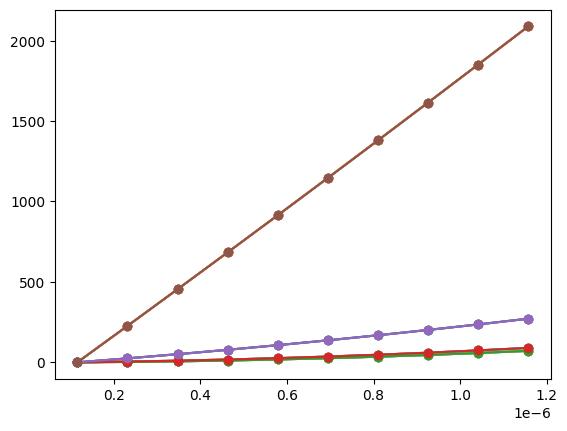

In [4]:
import matplotlib.pyplot as plt
sec_in_day = 24 * 60 * 60
for (k1, mu, sv, *rest), d in zip(P, D):
    time, volume = zip(*d)
    plt.plot([time / sec_in_day for time in time], [ (v - volume[0]) for v in volume], "o-");